# Assignment 5: Dense Vector Search
_Word Representations and Language Models (WS 24/25)_

Group Members: Buket Sak, Ludmila Bajuk, Alexander Weyhe
***

In this assignment, you will learn how to use language models for constructing a simple search engine. You will use three different approaches for obtaining document embeddings: Word2Vec, TF-IDF and Sentence-Transformer. Afterwards, we will experiment with index structures to reduce query times. Finally, you will compare the three approaches for retrieving relevant news articles given a short search query.

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#FFF2CC;border-color:#D6B656;color:#856404">
<b>How to Submit the Assignment</b>

Please work on this assignment in groups of two or three. Make sure to add your names to this files header. After completion, share this assignment with me (<b>Julian Schelb - <a target="blank" href="https://www.kaggle.com/julianschelb">https://www.kaggle.com/julianschelb</a></b>) due Wednesday, 4th December, 12:00. Use the upper-right share button as instructed in the tutorial. In ILIAS, submit this notebook as response to Assignment 05. You can download this notebook using the "Download Notebook" option in the "File" menu.
</div>

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from IPython.display import display
from time import time, process_time
from nltk.corpus import stopwords
from gensim import utils
from tqdm import tqdm
import gensim.downloader as api
import gensim.models
import pandas as pd
import numpy as np
import random
import json
import nltk

nltk.download('stopwords')
stop = set(stopwords.words('english'))
tqdm.pandas()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Task 1: Vector Search

In this task, you will train both a Word2Vec and TF-IDF model and use them to build a simple search engine.

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Load and Process the Dataset</b> 
</div>

First, you need to add [this](https://www.kaggle.com/datasets/julianschelb/newsdata) dataset containing news articles to your notebook. Click on "+Add data" and the dataset. In the first task, you will load and filter the data. Please implement the following steps:

1. Load the dataset by reading the CSV file _relevant_articles.json_.
2. Sample a training set consisting of 30,000 examples and a test set of 500 examples.

In [2]:
# Read article data
with open("../input/relevant_articles.json","rb") as d:
    relevant_articles = json.load(d)

In [3]:
import re
# Convert to DataFrame
articles = pd.json_normalize(relevant_articles)

# Preprocess data
non_alpha_pattern = re.compile(r"[^a-zA-Z0-9\s]")

# Tokenization and cleaning function
def preprocess(text):
    """Tokenize text, clean non-alphabetic characters, and remove stopwords."""
    # Remove line breaks
    text = text.replace('\n', ' ')
    # Remove non-alphabetic characters
    cleaned_text = non_alpha_pattern.sub(' ', text)
    cleaned_text = cleaned_text.lower()  # Normalize case
    tokens = [token for token in word_tokenize(cleaned_text) if token not in stop]
    cleaned_text = ' '.join(tokens)
    return cleaned_text
# Tokenization
def tokenize(text):
    """Tokenize text and remove stopwords."""
    # Tokenize the text into words
    tokens = word_tokenize(text)  # No stopword removal here, just tokenization
    return tokens

# Apply preprocessing and tokenization
articles['text'] = articles['text'].progress_apply(preprocess)
articles['tokens'] = articles['text'].progress_apply(tokenize)
articles['title'] = articles['title'].progress_apply(preprocess)

100%|██████████| 60795/60795 [00:05<00:00, 10926.73it/s]


In [4]:
# Preview previous and tokenized articles
articles[['title', 'text', 'tokens']].head()

,title,text,tokens
0,five steps fixing uk housing crisis 2016,headlines utter madness housing market dominat...,"[headlines, utter, madness, housing, market, d..."
1,enough assessments 2015 time look back 2016 ye...,strictly come dancing featuring vladimir putin...,"[strictly, come, dancing, featuring, vladimir,..."
2,paperback memoirs miss rice davies archive 1 j...,1 january 1964 mandy report turns slim paperba...,"[1, january, 1964, mandy, report, turns, slim,..."
3,drunk patient numbers revealed,ambulances attend 60 incidents average every d...,"[ambulances, attend, 60, incidents, average, e..."
4,littering fines set rise 150,penalties people drop litter could reach much ...,"[penalties, people, drop, litter, could, reach..."


In [5]:
# 30,000 samples for training and 500 samples for testing
train_data, test_data = train_test_split(articles, 
                                         train_size=30000, 
                                         test_size=500, 
                                         random_state=42)

# Verify the split
print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

# Preview the first few entries of the split data
print(train_data['tokens'].head())
print(test_data['tokens'].head())

Training data size: 30000
Testing data size: 500
41159    [speech, tuc, dinner, labour, leader, say, pla...
21835    [elite, athletes, carrying, hopes, nation, eur...
10640    [coming, days, weeks, writes, weis, voters, in...
52818    [rochester, new, york, voters, line, chance, h...
52477    [donald, trump, closing, campaign, ad, paints,...
Name: tokens, dtype: object
37217    [government, lawyers, first, legal, challenge,...
51093    [last, seen, screen, wronged, wife, striking, ...
8473     [president, obama, consideration, trip, hirosh...
1334     [group, doctors, health, experts, urging, hous...
47823    [donald, trump, selected, mike, pence, vice, p...
Name: tokens, dtype: object


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Train Word2Vec Model</b> 
</div>

Building on the code from previous assignments and using the news dataset you are already familiar with, train a Word2Vec model on the text of all news articles in your training set. We will use this model later to obtain documents embeddings. Please implement the following step:

- [Train a Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) model with the preprocessed articles. Specify a vector size of 768 before training. Set `epochs=10` for training. Depending on the size of your dataset, training may take ~10 minutes.

In [7]:
# Train the model
model_Word2vec = Word2Vec(
    sentences=train_data['tokens'],
    vector_size=768,   
    window=5,           
    workers=4,          
    epochs=10           
)

In [8]:
# Save the trained Word2Vec model to a file
model_Word2vec.save("/kaggle/working/word2vec_model.h5")

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Implement Vector Search (Word2Vec)</b> 
</div>

Now we want to use the model to search for similar news articles.

1. Start by implementing a function **compute_document_embedding(doc, model)** that computes the embedding for an entire document by averaging the embeddings of all words in the document.

2. Next, write a function **searchWithEmbedding(embeddings, model, query, N, stopwordflag)** to search for the “N” most similar news articles. Preprocess the query to remove stopwords if stopwordflag is enabled, then generate its embedding using compute_document_embedding. Compute cosine similarity between the query embedding and the precomputed document embeddings, sort the results in descending order, and return the top N indices and similarity scores.

3. To test your implementation, start by precomputing document embeddings for all articles in the test set using the `compute_document_embedding` function. Use a article from the test set as a query to test your `searchWithEmbedding` function. The function should identify the query article as the most similar match. Validate the results by comparing the retrieved articles and their similarity scores.

*(Hint: You can use cosine_similarity() from sklearn for similarity computation.)*

In [9]:
# Load model 
model_Word2vec = Word2Vec.load("./word2vec_model.h5")

In [10]:
def compute_document_embedding(doc, model):
    """Computes the document embedding by averaging word embeddings."""
    embeddings = [model.wv[word] for word in doc if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size) 

# Test your implementation
doc_embedding = compute_document_embedding("This is a test!", model_Word2vec)
print("Dimensions of the document embedding:", doc_embedding.shape)
print("Document embedding values:", doc_embedding[:10])  

Dimensions of the document embedding: (768,)
Document embedding values: [ 0.34331685 -0.44467285  0.21174581 -0.4802879   1.1937456  -0.49898016
 -0.21716474  1.0248697  -0.19286352  0.05455481]


In [11]:
# Encode sentences in test and dataset using word2vec
train_data['emb_word2vec'] = train_data['tokens'].apply(lambda doc: compute_document_embedding(doc, model_Word2vec))
test_data['emb_word2vec'] = test_data['tokens'].apply(lambda doc: compute_document_embedding(doc, model_Word2vec))

# Check embeddings in train dataset
print("Sample training data embedding:")
print(train_data['emb_word2vec'].iloc[0])

# Check if embedding dimensions are consistent
print("Embedding dimension consistency check:")
print("Train embedding shape:", train_data['emb_word2vec'].iloc[0].shape)
print("Test embedding shape:", test_data['emb_word2vec'].iloc[0].shape)

Sample training data embedding:
[-4.37394232e-02  6.34029880e-02 -1.01367883e-01  1.75058506e-02
 -3.17148834e-01  2.18965281e-02  4.71343622e-02 -2.46922910e-01
  2.72497326e-01 -2.71062125e-02 -1.76234528e-01  1.64454937e-01
  4.00321931e-02  8.37622806e-02 -2.42963992e-02 -9.77609456e-02
 -7.53748789e-02 -9.70122814e-02  2.84597814e-01  1.64978027e-01
  6.43306449e-02  1.39275610e-01  8.15550312e-02 -1.28558218e-01
  1.23494938e-01  2.00743735e-01  1.89169303e-01 -8.68231952e-02
 -5.04432321e-02  2.82726195e-02  4.07405458e-02 -2.46618893e-02
 -1.53276354e-01  1.73948929e-01  2.49865968e-02  6.21132040e-03
 -1.40272304e-01 -5.46152927e-02 -3.85105386e-02  7.21361712e-02
 -3.32186930e-02 -4.92478237e-02 -2.08176687e-01 -2.01414809e-01
  4.48788479e-02  1.37524158e-01 -1.02870882e-01  3.31510194e-02
  1.89033896e-01 -2.88152456e-01 -1.14525631e-01 -1.00479051e-01
  1.69261843e-02 -8.80875066e-02  3.71642560e-02 -1.58594269e-02
  3.54231633e-02  4.56264883e-01 -1.08056299e-01 -3.133825

In [12]:
# Implement function searchWithEmbedding(query, N, stopwordflag) 

def searchWithEmbedding(embeddings, model, query, N, stopwordflag=True, stopwords=stop):
    """Search for the top N similar documents to the query using embeddings."""
    # Preprocess query
    query_tokens = word_tokenize(query.lower())
    if stopwordflag and stopwords:
        query_tokens = [word for word in query_tokens if word not in stop]

    # Compute query embedding
    query_embedding = compute_document_embedding(query_tokens, model).reshape(1, -1)

    # Compute cosine similarities between query embedding and document embeddings
    similarities = [
        cosine_similarity(query_embedding, doc_embedding.reshape(1, -1))[0][0]
        for doc_embedding in embeddings
    ]
    # Get the indices of the top N most similar documents
    similar_doc_ids = np.argsort(similarities)[-N:][::-1] 
    sim_values = [similarities[i] for i in similar_doc_ids]  
    
    return similar_doc_ids, sim_values

In [13]:
# Test your search implementation
query = str(test_data["text"].iloc[42])
print("Query:\n" + query[0:400])

# Reset the index of test_data for consistency
test_data.reset_index(drop=True, inplace=True)

# Search for similar articles
embeddings = test_data["emb_word2vec"].tolist() 

similar_doc_ids, sim_values = searchWithEmbedding(embeddings, model_Word2vec, query, 10, True, stop)

# Display similar articles with titles and text
display(test_data.loc[similar_doc_ids, ["title", "text"]])

Query:
kenosha wis ted cruz well documented fondness cheese cheese themed headwear much ironclad rule politics funny hats texas senator said monday made way sprawling mars cheese castle stubbornly refusing famous yellow foam triangles meant look like chunks cheddar hat definition defined funny hat nodding 1988 presidential election cruz added michael dukakis demonstrated put helmet rode tank one cruz dau


,title,text
42,ted cruz yea cheese nay foam cheeseheads,kenosha wis ted cruz well documented fondness ...
346,cruz team attacks trump touting tyson endorsem...,campaign sen ted cruz one pacs attacking rival...
410,calculated drama trump rnc,shakespearian word msnbc used describe rnc fol...
394,fake trump bagpiper guy ram horn meet sidewalk,god decided election man shouted underneath gi...
19,ted cruz wallops donald trump wisconsin gop pr...,good news establishment forces hoping stop don...
383,clinton says gop convention perversely flattering,tampa rally hillary clinton talked republican ...
388,sen mike lee urges trump quit utah republicans...,sen mike lee r utah one republican senators ne...
6,ted cruz massive political gamble explained,ted cruz risked political career wednesday nig...
245,search lesbian donald trump supporter,like finding unicorn haystack end rainbow wash...
226,gop veep candidate trump compatible fix analysis,want serve gop vice presidential nominee year ...


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 4: Implement Vector Search (TF-IDF)</b> 
</div>

For comparison, we will also train a TF-IDF model to encode documents. Recall your background knowledge of the vector space model and [TF-IDF](http://www.tfidf.com). 
Create a TF-IDF-weighted term-document matrix from the news articles. You may use the [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) method from sklearn. 
For simplicity, use stemming to create word stems (instead of 
lemmatization). Use the [SnowballStemmer](https://www.nltk.org/api/nltk.stem.snowball.html) from nltk. Processing can take ~5 min.

1. Write a function **searchWithTFIDF(embeddings, vectorizer, query, N, stopwordflag)** with similar functionality to the search function you implemented as part of Step 3. Internally, the function should convert the query string to a TF-IDF-vector and use cosine similarity to find the N most similar documents. 

2. Use the TF-IDF-vectorizer to embed all the articles in the test set. Finally, test your implementation as you did for Step 3.

*(Hint: You can find the N highest values in a list using this code snippet: "(-list).argsort()[:N])"*

In [14]:
# Make sure the index equals row number
test_data.reset_index(drop=True, inplace=True)
# Define stemmer
stemmer = SnowballStemmer('english')
# Stem words in all articles
def preprocess_text_with_stemming(text, stopwordflag=True, stopwords=stop):
    """Preprocess text by tokenizing, removing stopwords (if flag is True), and applying stemming."""
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    
    if stopwordflag and stopwords:
        tokens = [word for word in tokens if word not in stopwords]  # Remove stopwords
    
    # Apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return " ".join(stemmed_tokens)

In [15]:
# Create tfidf model + fit/transform article data
def create_tfidf_model(documents, stopwordflag=True, stopwords=stop):
    """Create a TF-IDF model and transform the documents."""
    # Preprocess documents
    preprocessed_docs = [preprocess_text_with_stemming(doc, stopwordflag, stopwords) for doc in documents]
    
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(preprocessed_docs)
    
    return tfidf_matrix, vectorizer

# Apply the TF-IDF model on the test set
tfidf_matrix, vectorizer = create_tfidf_model(test_data["text"], stopwordflag=True, stopwords=stop)

In [16]:
# Implement function searchWithTFIDF(query, N, stopwordflag) 

def searchWithTFIDF(tfidf_matrix, vectorizer, query, N, stopwordflag=True, stopwords=stop):
    """Search for the top N similar documents to the query using TF-IDF embeddings."""
    
    # Preprocess query text with stemming
    query_preprocessed = preprocess_text_with_stemming(query, stopwordflag, stopwords)
    
    # Convert query to TF-IDF vector
    query_tfidf = vectorizer.transform([query_preprocessed])
    
    # Compute cosine similarities between the query and all document embeddings
    similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()
            
    # Get top N indices with highest similarity scores
    similar_doc_ids = (-similarities).argsort()[:N]
    sim_values = [similarities[i] for i in similar_doc_ids]
    
    return similar_doc_ids, sim_values

In [17]:
# Test your search implementation
query = str(test_data["text"][42])
print("Query:\n" + query[0:400])

# Search for similar articles
similar_doc_ids, sim_value = searchWithTFIDF(tfidf_matrix, vectorizer, query, 10, True)
display(test_data.loc[similar_doc_ids][ ["title", "text"] ])

Query:
kenosha wis ted cruz well documented fondness cheese cheese themed headwear much ironclad rule politics funny hats texas senator said monday made way sprawling mars cheese castle stubbornly refusing famous yellow foam triangles meant look like chunks cheddar hat definition defined funny hat nodding 1988 presidential election cruz added michael dukakis demonstrated put helmet rode tank one cruz dau


,title,text
42,ted cruz yea cheese nay foam cheeseheads,kenosha wis ted cruz well documented fondness ...
430,quiet cruz weighs role trump convention revolt,cleveland ap sen ted cruz refusing condemn reb...
19,ted cruz wallops donald trump wisconsin gop pr...,good news establishment forces hoping stop don...
6,ted cruz massive political gamble explained,ted cruz risked political career wednesday nig...
410,calculated drama trump rnc,shakespearian word msnbc used describe rnc fol...
35,cruz sanders angle wins wisconsin primaries,milwaukee ap republican ted cruz democrat bern...
412,newt gingrich says ted cruz welcome future rep...,donald trump first challenge crowned republica...
86,pro cruz super pac hit kasich tv ad ahead new ...,super pac supporting ted cruz campaign preside...
346,cruz team attacks trump touting tyson endorsem...,campaign sen ted cruz one pacs attacking rival...
392,trump says supporters hesitant tell pollsters ...,green bay wis donald trump said monday polls a...


In [18]:
print(tfidf_matrix.shape)  
print(tfidf_matrix[0].toarray())  
test_data["emb_tfidf_dense"] = [tfidf_matrix[i].toarray().flatten() for i in range(tfidf_matrix.shape[0])]
print(test_data[["title", "emb_tfidf_dense"]].head())

(500, 12993)
[[0. 0. 0. ... 0. 0. 0.]]
                                               title  \
0  theresa may intend trigger article 50 year cou...   
1  demelza take revenge cheating poldark rape sce...   
2  japanese american congressman urges obama visi...   
3               doctors urge cut drink driving limit   
4  like nixon 1968 pence could become consensus g...   

                                     emb_tfidf_dense  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.05171369569433551, 0.0, 0.0, 0.0, 0.0,...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.010723961744695636, 0.0, 0.0, 0.0, 0.0...  


## Task 2: Approximate Nearest Neighbors Search

In previous tasks, we utilized Word2Vec and TF-IDF to encode documents as points in vector space. To search for similar documents (i.e. articles), we needed to  compare the query with **every** document in the corpus, using cosine similarity as metric. This can result in long query times if we work with larger document collections.

To reduce query times, libraries like [Annoy](https://github.com/spotify/annoy) create indices by organizing the document embeddings in a tree like structure. At every node in the tree, the vector space is divided into two subspaces. This reduces the search space for nearest neighbor searches. Consequently, the number of comparisons is reduced because it is no longer necessary to compare the query with all documents in the corpus. Retrieving similar documents can therefore be done much faster.

svg image


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Compare Query Runtimes</b> 
</div>

In theory, indexing the articles should reduce query times. To validate this claim, we will compare the query times using Annoy against Word2Vec for different corpus sizes. Please implement the following steps:

**Without an index:** 

1. Create lists of document embeddings for datasets containing 10000, 15000, 20000, 25000, and 30000 documents without using an index. These lists will serve as a baseline for linear scans.

2. Measure the average query time for 100 queries on each dataset size without an index. For each query:
    - Compute the query embedding using the `compute_document_embedding()` function.
    - Compare it to all document embeddings by calculating cosine similarity.
    - Sort the results and identify the 10 most similar documents.
    - Record the average query time for this approach.

**With an index:**

3. Build Annoy indices for datasets containing 10000, 15000, 20000, 25000, and 30000 documents. Use the article IDs as keys and their averaged Word2Vec embeddings as values. Refer to the [Annoy documentation](https://github.com/spotify/annoy) for detailed instructions on creating indices.

4. Measure the average query time for 100 queries on each dataset size with an index. For each query:
    - Compute the query embedding using the `compute_document_embedding()` function.
    - Use Annoy’s `.get_nns_by_vector()` method to retrieve the 10 most similar documents directly from the index.
    - Record the average query time for this approach.

**Compare:**

5. Plot the results on a line chart, with the number of documents in the dataset on the x-axis and the average query time on the y-axis. Include separate lines for query times with and without an index to compare the two approaches.

*(Hint: Randomly select articles to use as queries. Measure only the query execution time, not preprocessing, to evaluate the performance of the data structures.)*

In [19]:
# Function for creating an annoy index
from annoy import AnnoyIndex
articles.reset_index(drop=True, inplace=True)

def buildDocumentIndex(model, articles, n, vector_size=768):
    """Builds an Annoy index for the given articles using their Word2Vec embeddings."""

    index = AnnoyIndex(vector_size, 'angular')  
    
    for i, tokens in enumerate(articles[:n]):
        embedding = compute_document_embedding(tokens, model)  
        index.add_item(i, embedding)  
    
    index.build(10) 
    return index

In [20]:
# Measure average runtime using an Annoy index
import time

def measureQueryAnnoy(model, article_index, articles, queries=100):
    """Measure average query runtime for Annoy index."""
    query_times = []
    
    # Randomly select queries
    random_queries = random.sample(range(len(articles)), queries)
    for i in random_queries:
        query_tokens = articles[i]
        
        query_embedding = compute_document_embedding(query_tokens, model)
        
        # Search for the nearest neighbors
        article_index.get_nns_by_vector(query_embedding, 10)

        start_time = time.time()  
        query_time = time.time() - start_time
        query_times.append(query_time)
    return np.mean(query_times)  

In [21]:
# Measuring average runtime word2vec
from scipy.spatial.distance import cosine

def measureQueryWord2Vec(embeddings, model, queries, corpus_size):
    """Measure average query runtime using searchWithEmbedding and a limited corpus."""
    
    query_times = []
    
    random_queries = random.sample(range(min(len(embeddings), corpus_size)), queries)

    for i in random_queries:
        query_tokens = embeddings[i]  
        query_embedding = compute_document_embedding(query_tokens, model)

        start_time = time.time()
        similarities = [
            1 - cosine(query_embedding, compute_document_embedding(tokens, model))
            for tokens in embeddings[:corpus_size]
        ]
        sorted_similarities = sorted(enumerate(similarities), key=lambda x: x[1], reverse=True)[:10]
        query_time = time.time() - start_time
        query_times.append(query_time)

    return np.mean(query_times) 

In [22]:
tokenized_articles = test_data["tokens"].tolist() 
N = [10000, 15000, 20000, 25000, 30000]#, 40000, 50000, 60000]

runtimes_annoy = []
runtimes_default = []

# Load your Word2Vec model (ensure it's trained and saved before running this part)
model_Word2vec = Word2Vec.load("./word2vec_model.h5")  # Load your trained model

for n in N:
    print("\nTesting with", str(n), "documents:")

    # Build Annoy index
    article_index = buildDocumentIndex(model_Word2vec, tokenized_articles, n, vector_size=768)
    
    # Measure query time using annoy
    avg_time_annoy = measureQueryAnnoy(model_Word2vec, article_index, tokenized_articles, queries=100)
    runtimes_annoy.append(avg_time_annoy)
    
    # Measure query time using Word2Vec (linear scan)
    avg_time_word2vec = measureQueryWord2Vec(tokenized_articles, model_Word2vec, queries=100, corpus_size=n)
    runtimes_default.append(avg_time_word2vec)
    
    print(f"Average query time with Annoy index: {avg_time_annoy:.4f} seconds")
    print(f"Average query time without index (linear scan): {avg_time_word2vec:.4f} seconds")



Testing with 10000 documents:
Average query time with Annoy index: 0.0000 seconds
Average query time without index (linear scan): 0.5008 seconds

Testing with 15000 documents:
Average query time with Annoy index: 0.0000 seconds
Average query time without index (linear scan): 0.5017 seconds

Testing with 20000 documents:
Average query time with Annoy index: 0.0000 seconds
Average query time without index (linear scan): 0.5064 seconds

Testing with 25000 documents:
Average query time with Annoy index: 0.0000 seconds
Average query time without index (linear scan): 0.5016 seconds

Testing with 30000 documents:
Average query time with Annoy index: 0.0000 seconds
Average query time without index (linear scan): 0.5017 seconds


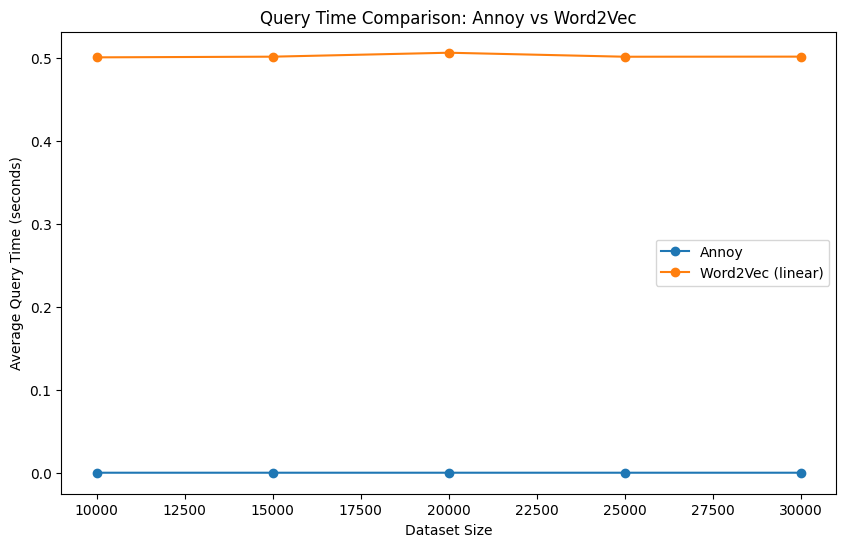

In [23]:
# Plot the runtimes
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(N, runtimes_annoy, label="Annoy", marker="o")
plt.plot(N, runtimes_default, label="Word2Vec (linear)", marker="o")
plt.xlabel("Dataset Size")
plt.ylabel("Average Query Time (seconds)")
plt.legend()
plt.title("Query Time Comparison: Annoy vs Word2Vec")
plt.show()

## Task 3: State-Of-The-Art Models

In this week's paper you will learn about [Attention](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) and later about the [Transformer Architecture](https://jalammar.github.io/illustrated-transformer/). At this stage, it is not required to understand the transformer architecture, but for comparison’s sake we want to include it in this week's assignment. 

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Load the Model and Encode the Articles</b> 
</div>

We will use the [sentence-transformers](https://www.sbert.net/index.html) package to encode news articles. A sentence-transformer can be seen as a modification of the transformer architecture and allows us to encode documents (i.e. news articles). 

Please implement the following steps:

 1. Load the pretrained model [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) using the [sentence-transformers](https://www.sbert.net/index.html) package. You may need to install the package with the provided terminal command.
 2. Encode all articles in the dataset. You want to enable GPU acceleration for this. Runtime should be ~2 min with GPU.

In [24]:
!pip install -q sentence_transformers --disable-pip-version-check --root-user-action=ignore 

In [25]:
import torch

# Check if GPU is available 
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

# Otherwise use the CPU
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: Tesla T4


In [26]:
from sentence_transformers import SentenceTransformer
# Load the transformer-based model
model_Transformer = SentenceTransformer('all-mpnet-base-v2')

# Encode all articles 
article_embeddings = model_Transformer.encode(train_data['text'].tolist(), show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

 <div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Implement Vector Search</b> 
</div>
 
To avoid linear search through all embeddings and long runtimes, use the Annoy (Approximate Nearest Neighbors Oh Yeah) package implementing an approximate k-nearest neighbor algorithm built upon an index tree (https://github.com/spotify/annoy).
 
 1. Use [Annoy](https://github.com/spotify/annoy) to index the articles. Building the index on all articles takes about 5 minutes.
 2. Write a function **searchWithTransformer(mode, query, N, stopwordflag)** with similar functionality to the previous implemented functions. Internally, the function should encode a query and use the document index to find similar documents.
 3. To test your implementation, use one entire article as query.

In [30]:
# Use annoy to build the document index 
def build_annoy_index(article_embeddings, model, vector_size=768, n_trees=10):
    # Create the Annoy index
    index = AnnoyIndex(vector_size, 'angular')

    # Add items to the Annoy index
    for i, embedding in enumerate(article_embeddings):
        index.add_item(i, embedding)

    # Build the index with specified number of trees (higher = more accurate)
    index.build(n_trees)
    return index


article_index = build_annoy_index(article_embeddings, model_Transformer, vector_size=768, n_trees=10)

In [42]:
# Implement function searchWithContextualEmbedding(query, N, stopwordflag) 

def searchWithTransformer(model, article_index, query, N, stopwordflag=False):
    # Preprocess and encode the query
    query_embedding = model.encode([query], device=device)  # Convert query into embedding
    
    # Use Annoy index to search for the N most similar documents
    top_indices, sim_values = article_index.get_nns_by_vector(query_embedding[0], N, include_distances=True)  # Get top N indices
    
    # Return the indices of the top N most similar documents
    return top_indices, sim_values

In [48]:
# Test your search implementation

# Define query
query = test_data["text"][42]
print("Query:\n" + query[0:400])

# Search for similar articles
similar_doc_ids, sim_value = searchWithTransformer(model_Transformer, article_index, query, 10, False)
display(train_data.iloc[similar_doc_ids][["title", "text"]])

Query:
kenosha wis ted cruz well documented fondness cheese cheese themed headwear much ironclad rule politics funny hats texas senator said monday made way sprawling mars cheese castle stubbornly refusing famous yellow foam triangles meant look like chunks cheddar hat definition defined funny hat nodding 1988 presidential election cruz added michael dukakis demonstrated put helmet rode tank one cruz dau


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,title,text
8870,philly candidates face crucial cheesesteak test,des moines iowa ap five point plans engaging s...
39768,candidates hungry votes show ohio food favorites,cincinnati ap candidates hungry votes one pivo...
34860,paul ryan confident keeping seat cautious house,mount pleasant wis house speaker paul ryan nav...
5836,donald trump seizes old target wisconsin scott...,donald trump merciless wednesday portrayal poo...
6705,iowa cafe changes menu call chuck grassley sup...,slice constitution quiche anyone washington de...
6573,huffpost hill trump coverage downgraded wall w...,donald trump children vote new york though pre...
5396,gop race moves new york trump dominates,new york celebrating gop primary win wisconsin...
18209,sunday roundup,week nation looked horrified silverback gorill...
16250,donald trump keeps attacking fellow republicans,fresh string attacks donald trump week rivals ...
49090,inside week trump rallies talk rigged election...,wrapped rally cincinnati arena thursday night ...


## Task 4: Comparison

Now that we implemented a simple search engine based on three different models, we want to compare them. As a test scenario, we simulate a news article search, where users can enter a short query and our service returns relevant news articles. To measure how well our three models would perform in such a scenario, we will use the article titles to simulate search queries. The objective for a real search engine would be to present a list of related news articles to the user, with the one corresponding to the title as one of the first search results (typically called the "10 blue links" in search engine development for obvious reasons).

Please implement the following steps:

1. Use the article titles in the test set as queries. Make use of the functions you implemented before to determine at what position the given model ranks the corresponding article among all articles in the test set (i.e. set N to the number of articles in the dataset). Do this for the word2vec, TF-IDF and Transformer model. Experiment with removing stopwords.
2. Calculate the average position for each model over all articles you sampled. A perfect model would always return the corresponding article ID at position 0.
3. Visualize the results as a cumulative recall curve with the list position on the x-axis and the percentage of items that appear at that position or less on the y-axis. The resulting curve is monotonically increasing.
4. Interpret the results. Which model yields the best results?

**Discuss your results:**